In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf

In [2]:
from imblearn.over_sampling import SMOTE
#!pip install -U imbalanced-learn

# Open Data

In [3]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','dangermond_and_campuspoint.csv')
features_df = pd.read_csv(fp)

In [4]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','dangermond_non_iceplant.csv')
features_df = pd.concat([features_df,pd.read_csv(fp)])

In [5]:
features_df.drop(['geometry','Unnamed: 0','x','y','day','year'],axis=1,inplace=True)
ipf.iceplant_proportions(features_df.iceplant.to_numpy())

no-iceplant:iceplant ratio     3.8 :1
          counts  percentage
iceplant                    
0          20999       79.04
1           5567       20.96



# Split into train/test

In [6]:
train_features, test_features, train_labels, test_labels = ipf.test_train_from_df(features_df)

ipf.train_test_shapes(train_features, train_labels, test_features, test_labels)
ipf.test_train_proportions(train_labels, test_labels)

Training Features Shape: (18596, 5)
Training Labels Shape: (18596,)
Testing Features Shape: (7970, 5)
Testing Labels Shape: (7970,)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     3.7 :1
          counts  percentage
iceplant                    
0          14650       78.78
1           3946       21.22

TEST SET COUNTS:
no-iceplant:iceplant ratio     3.9 :1
          counts  percentage
iceplant                    
0           6349       79.66
1           1621       20.34



# MODEL: standard rfc

In [7]:
rfc = RandomForestClassifier(n_estimators = 100, 
                                      random_state = 42)
rfc.fit(train_features,train_labels)

predictions = rfc.predict(test_features)
ipf.print_threshold_metrics(test_labels, predictions)


true negatives: 6246     false positives: 103
false negatives: 142     true positives: 1479

sensitivity (TP/P): 91.24 %
specificity (TN/N): 98.38 %
G-mean:  0.95

precision (TP/(TP+FP)): 93.49 %

MCC:  0.9043824761286808

F1-measure:  0.92351
F0.5-measure (min false positives):  0.93031
F2-measure (min false negatives)  :  0.91681

accuracy: 96.93 %



/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_1836/4123860025.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=7   # manually add date


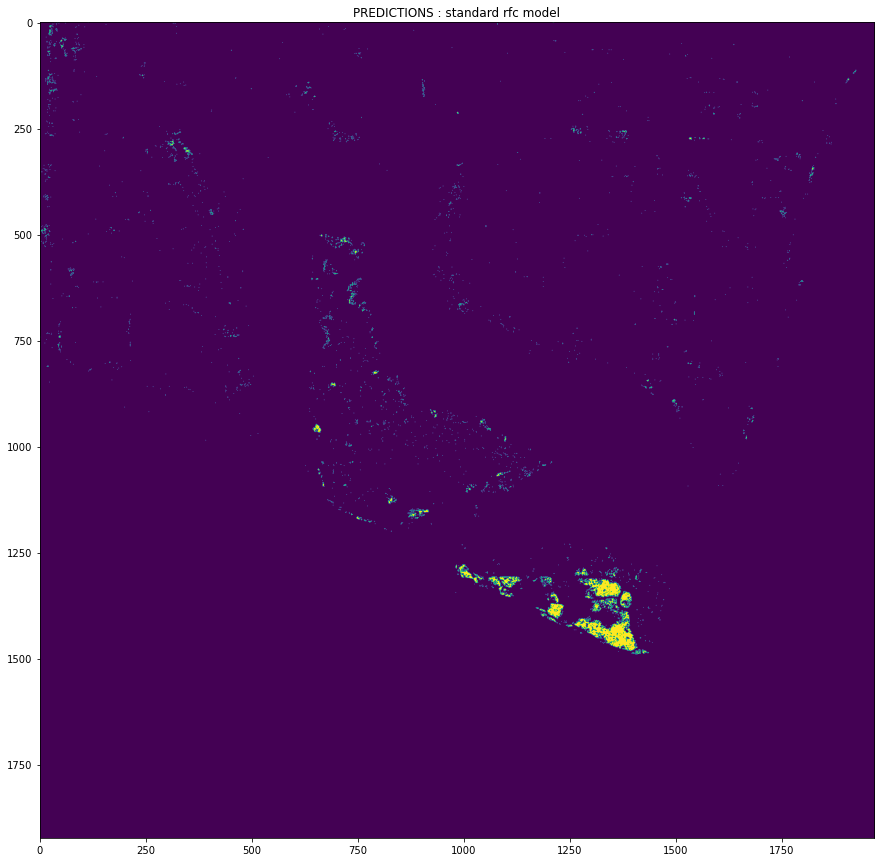

In [8]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

image = ipf.open_window_in_scene(cp.itemid, cp.geometry)
veg = ipf.select_ndvi_df(image)
veg['month']=7   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model")
ax.imshow(predictions)
plt.show()

# MODEL: balanced rfc

In [9]:
rfc_balanced = RandomForestClassifier(n_estimators = 100, 
                                      random_state = 42,
                                      class_weight='balanced')
rfc_balanced.fit(train_features,train_labels)
predictions_balanced = rfc_balanced.predict(test_features)
ipf.print_threshold_metrics(test_labels, predictions_balanced)


true negatives: 6251     false positives: 98
false negatives: 141     true positives: 1480

sensitivity (TP/P): 91.3 %
specificity (TN/N): 98.46 %
G-mean:  0.95

precision (TP/(TP+FP)): 93.79 %

MCC:  0.906663252872216

F1-measure:  0.92529
F0.5-measure (min false positives):  0.93281
F2-measure (min false negatives)  :  0.91789

accuracy: 97.0 %



# MODEL: SMOTE(1:1)

In [10]:
# create test and train sets with SMOTE
oversample = SMOTE(sampling_strategy=1)
over_train_features, over_train_labels = oversample.fit_resample(train_features, train_labels)
ipf.iceplant_proportions(over_train_labels)

no-iceplant:iceplant ratio     1.0 :1
          counts  percentage
iceplant                    
0          14650        50.0
1          14650        50.0



In [11]:
#Build SMOTE rfc model
smote_srf = RandomForestClassifier(n_estimators=100, random_state=42)

smote_srf.fit(over_train_features, over_train_labels)

smote_predictions = smote_srf.predict(test_features)

ipf.print_threshold_metrics(test_labels, smote_predictions)


true negatives: 6199     false positives: 150
false negatives: 104     true positives: 1517

sensitivity (TP/P): 93.58 %
specificity (TN/N): 97.64 %
G-mean:  0.96

precision (TP/(TP+FP)): 91.0 %

MCC:  0.9028187042400541

F1-measure:  0.92275
F0.5-measure (min false positives):  0.91507
F2-measure (min false negatives)  :  0.93056

accuracy: 96.81 %



In [12]:
#### KFOLD CROSSVALIDATION ---- NEED TO REDO THIS SECTION

# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import RepeatedStratifiedKFold
# #Create Stratified K-fold cross validation

# labels = np.array(features_df['iceplant'])
# #Convert to numpy array
# features = np.array(features_df.drop('iceplant', axis = 1))

# cv = RepeatedStratifiedKFold(n_splits=10, 
#                              n_repeats=3, 
#                              random_state=1)
# scoring = ('f1', 'recall', 'precision')
# #Evaluate SRF model
# scores = cross_validate(rfc, features, labels, scoring=scoring, cv=cv)

# #Get average evaluation metrics
# print('Mean f1: %.3f' % np.mean(scores['test_f1']))
# print('Mean recall: %.3f' % np.mean(scores['test_recall']))
# print('Mean precision: %.3f' % np.mean(scores['test_precision']))

In [13]:
# print('Mean f1: %.3f' % np.mean(scores['test_f1']))
# print('Mean recall: %.3f' % np.mean(scores['test_recall']))
# print('Mean precision: %.3f' % np.mean(scores['test_precision']))

# STANDARD RFC PREDICTIONS OVER DANGERMOND LOCATIONS

## CONCEPTION POINT

### AOI

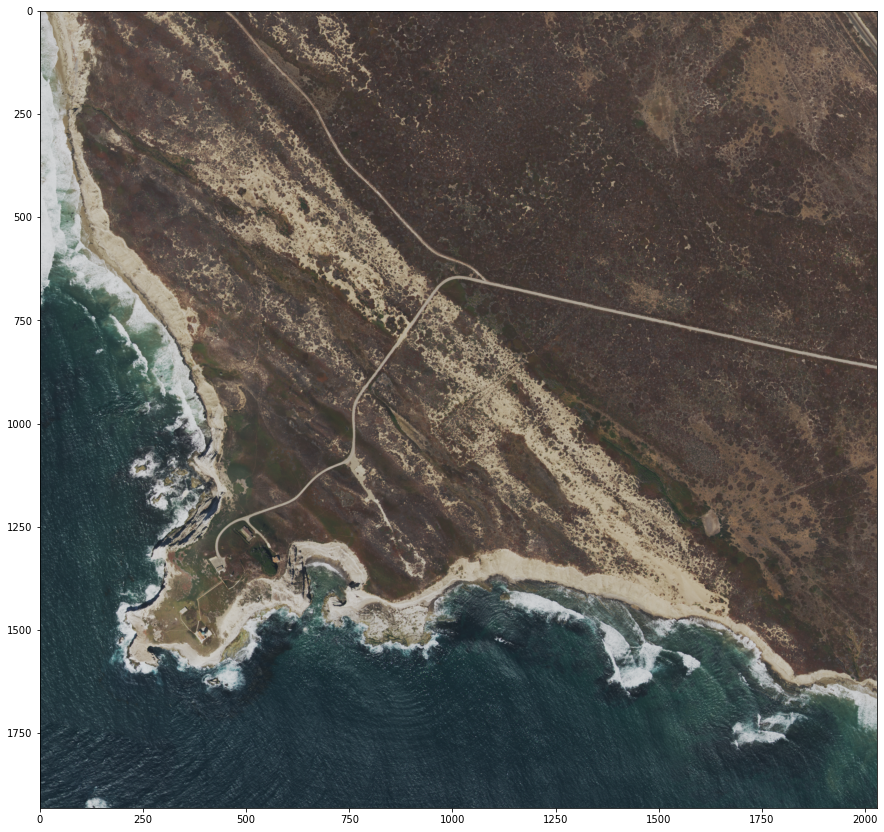

In [14]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[4]  # Conception Point

ipf.plot_window_in_scene(cp.itemid, cp.geometry)

### Model predictions

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_1836/1345326799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=9   # manually add date


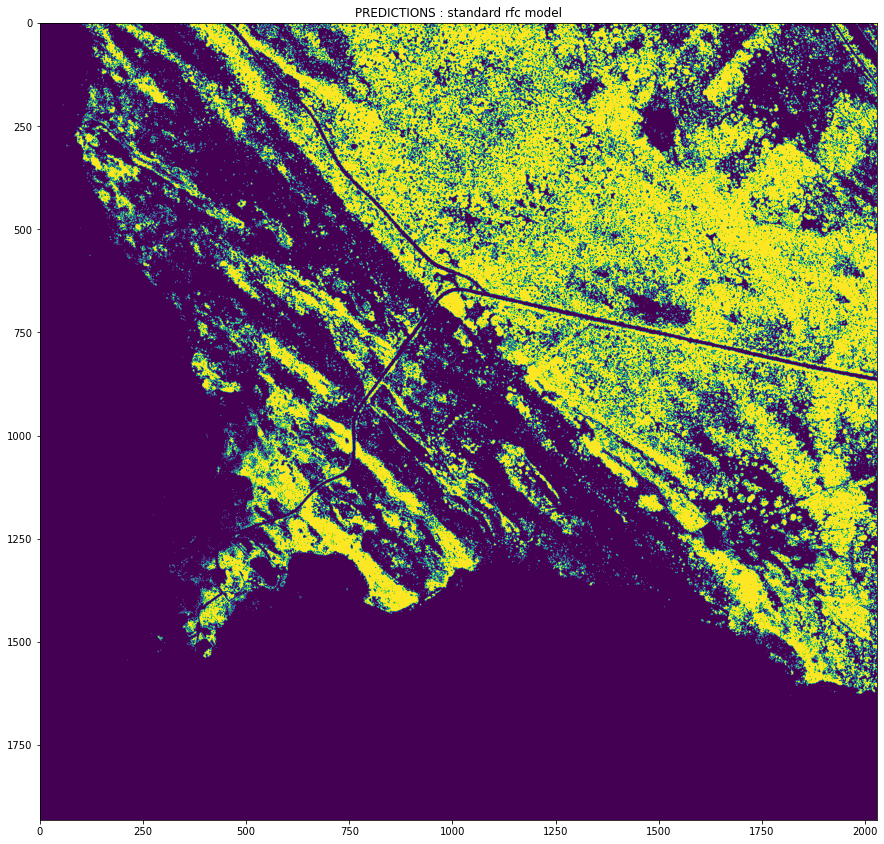

In [15]:
image = ipf.open_window_in_scene(cp.itemid, cp.geometry)
veg = ipf.select_ndvi_df(image)
veg['month']=9   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model")
ax.imshow(predictions)
plt.show()

### Vegetation not classified as iceplant

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


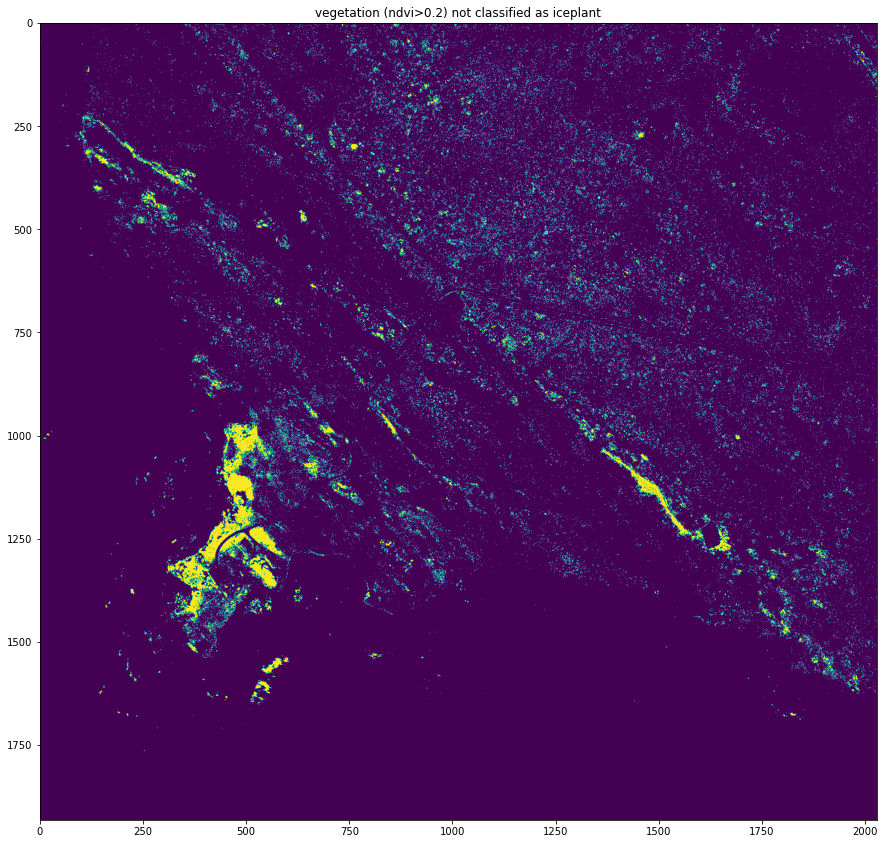

In [16]:
dgm_ndvi = ipf.select_ndvi_image(cp.itemid, cp.geometry)

diff = dgm_ndvi - predictions
fig, ax = plt.subplots(figsize=(15, 15))
plt.title('vegetation (ndvi>0.2) not classified as iceplant')
ax.imshow(diff)
plt.show()

## GOVERNMENT POINT

### AOI

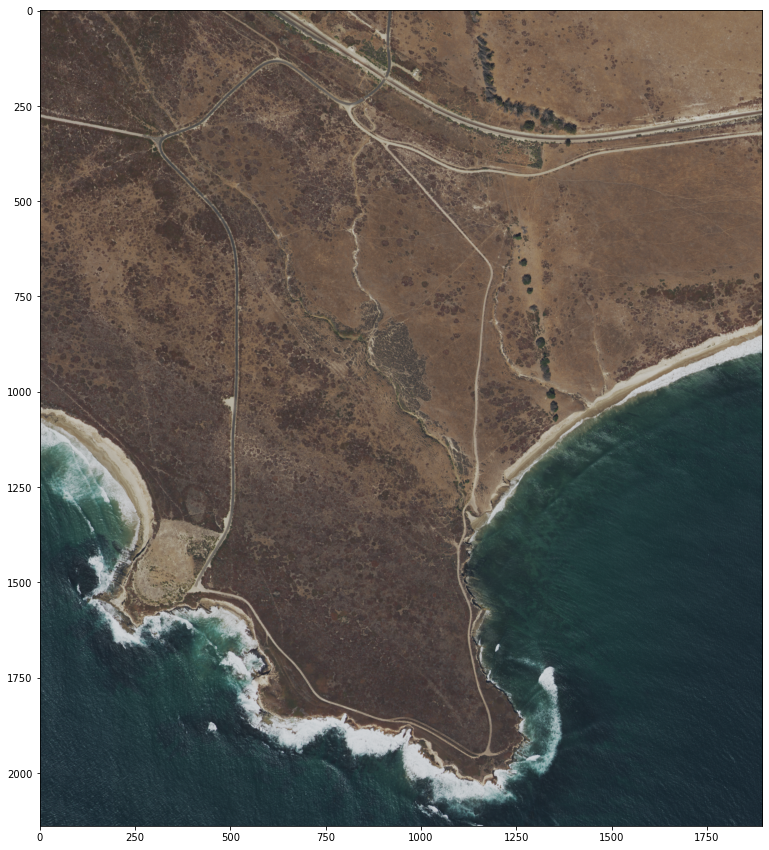

In [17]:
itemid = 'ca_m_3412037_nw_10_060_20180913_20190208'
dgm_box = Polygon([[-120.460019017,34.4418925647],
                   [-120.4479817528,34.4418925647],
                   [-120.4479817528,34.4532118881],
                   [-120.460019017,34.4532118881],
                   [-120.460019017,34.4418925647]])

ipf.plot_window_in_scene(itemid,dgm_box)

## Predictions

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_1836/510901071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=9   # manually add date


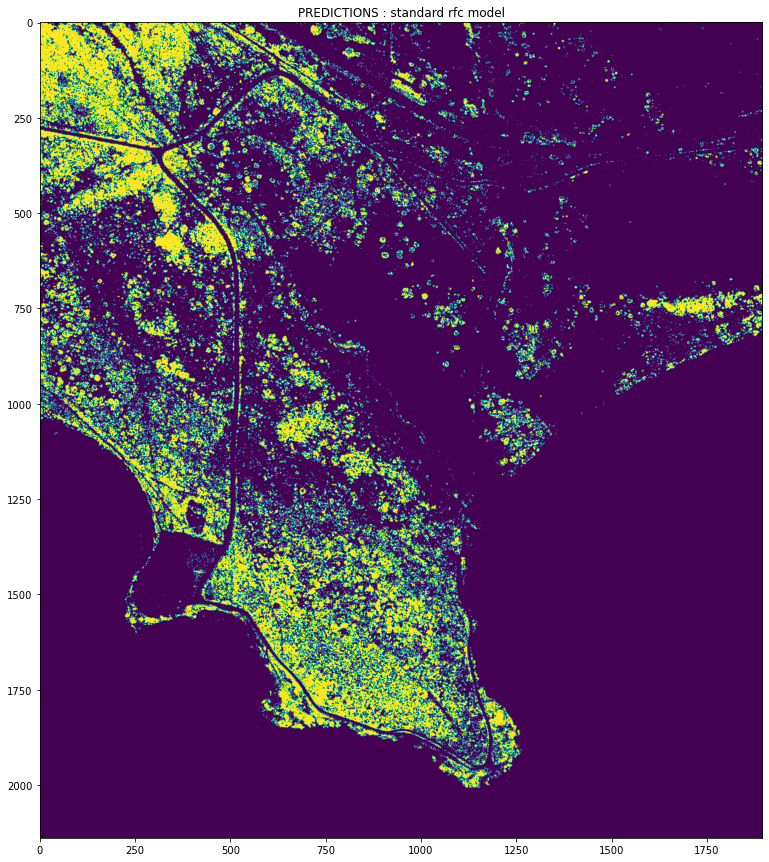

In [18]:
image = ipf.open_window_in_scene(itemid, dgm_box)
veg = ipf.select_ndvi_df(image)
veg['month']=9   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model")
ax.imshow(predictions)
plt.show()

### Vegetation not classified as iceplant

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


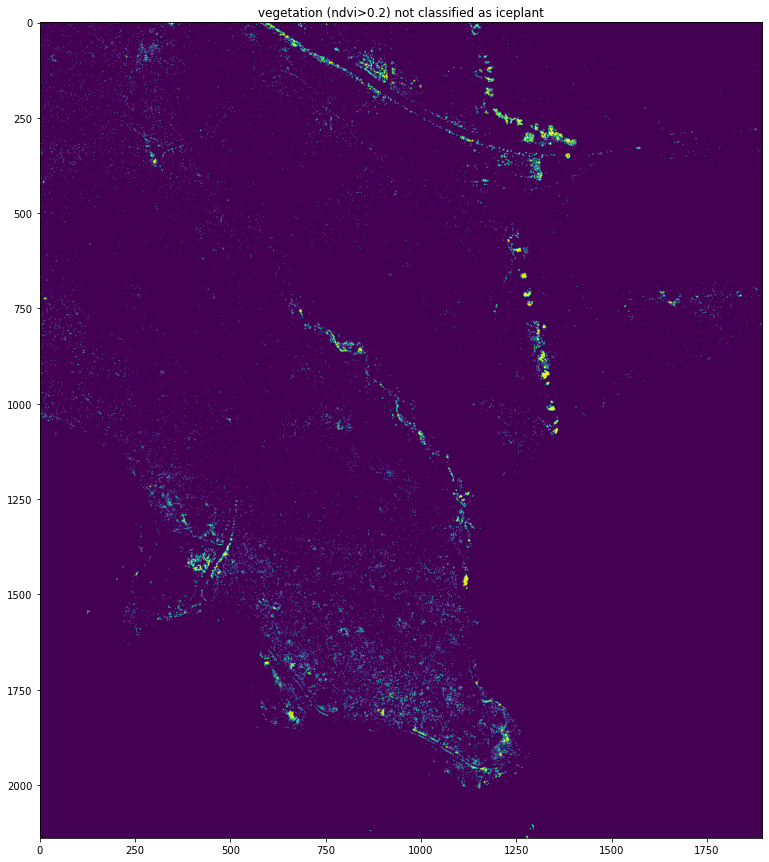

In [19]:
dgm_ndvi = ipf.select_ndvi_image(itemid,dgm_box)

diff = dgm_ndvi-predictions
fig, ax = plt.subplots(figsize=(15, 15))
plt.title('vegetation (ndvi>0.2) not classified as iceplant')
ax.imshow(diff)
plt.show()

## INLAND

### AOI

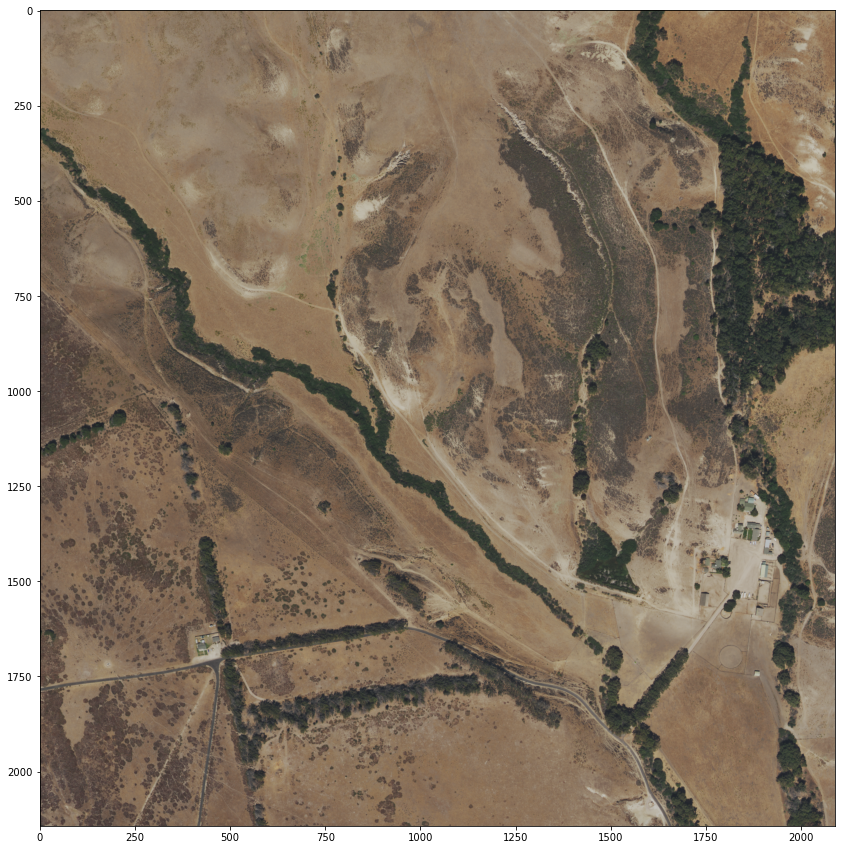

In [20]:
dgm_box = Polygon([[-120.4562449253,34.4542691265],
                    [-120.4429462156,34.4542691265],
                    [-120.4429462156,34.4655867726],
                    [-120.4562449253,34.4655867726],
                    [-120.4562449253,34.4542691265]])

ipf.plot_window_in_scene(itemid,dgm_box)

### Predictions

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_1836/510901071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=9   # manually add date


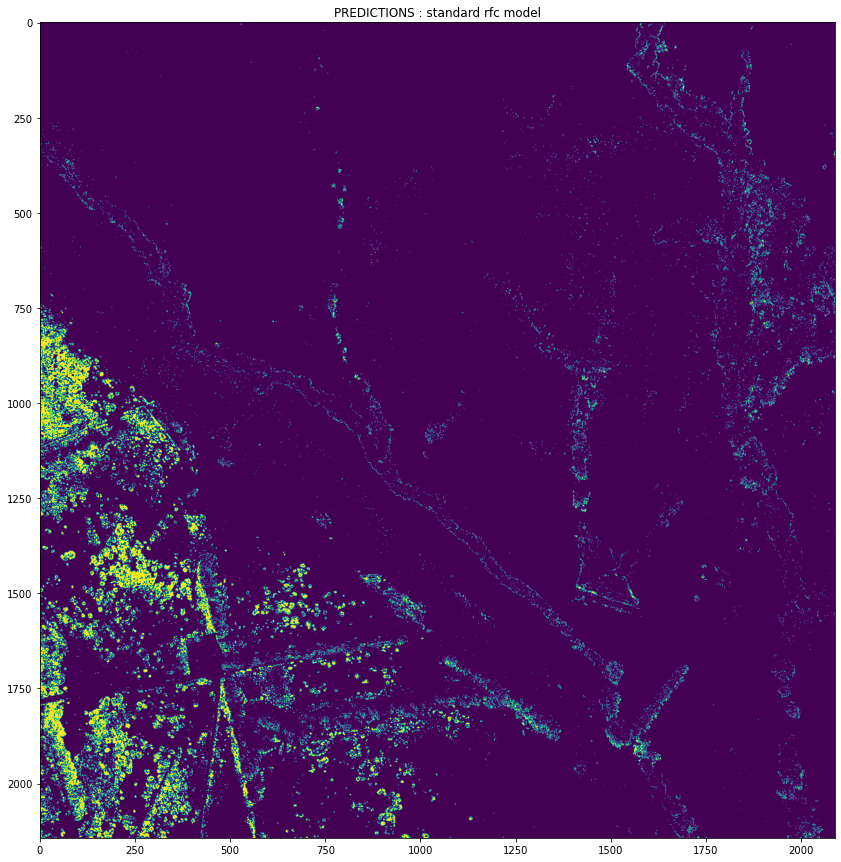

In [21]:
image = ipf.open_window_in_scene(itemid, dgm_box)
veg = ipf.select_ndvi_df(image)
veg['month']=9   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : standard rfc model")
ax.imshow(predictions)
plt.show()

### Vegetation not classified as iceplant

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


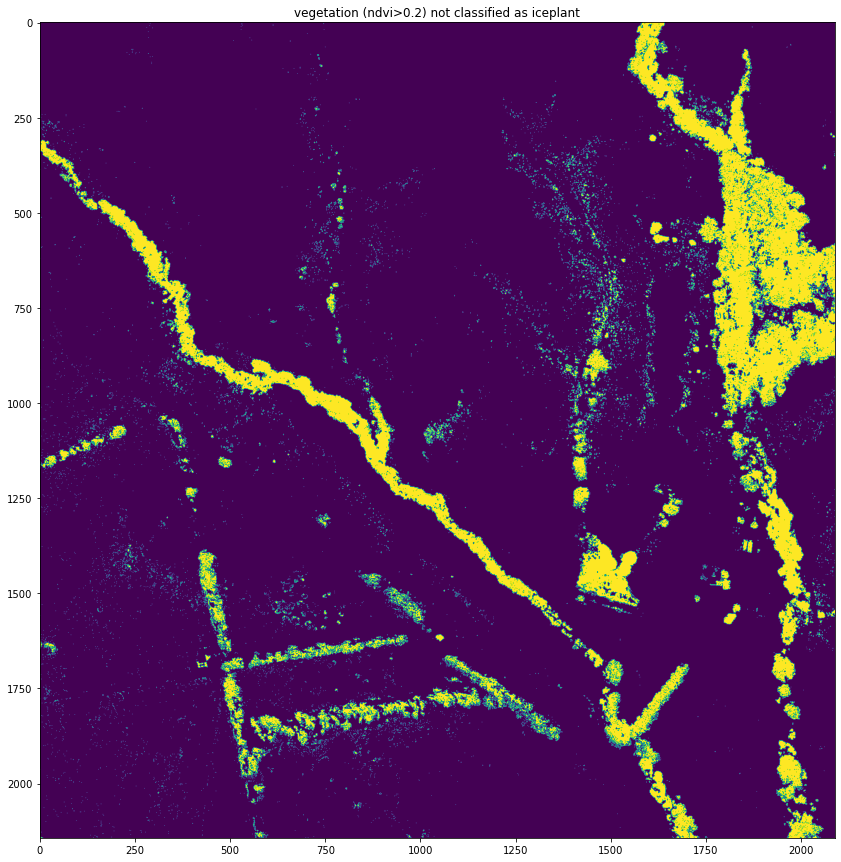

In [22]:
dgm_ndvi = ipf.select_ndvi_image(itemid,dgm_box)

diff = dgm_ndvi-predictions
fig, ax = plt.subplots(figsize=(15, 15))
plt.title('vegetation (ndvi>0.2) not classified as iceplant')
ax.imshow(diff)
plt.show()